In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
from sklearn.metrics import r2_score
import pickle

# If you would prefer to load the '.h5' example file rather than the '.pickle' example file. You need the deepdish package
# import deepdish as dd 

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import WienerFilterDecoder


In [2]:
folder='C:/Users/Jon/Documents/Biomedical Engineering - IC/4. letnik/Final Year Project/Python/Neural_Decoding/Data/'

with open(folder+'Ordered_data.pickle','rb') as f:
#     neural_data,vels_binned=pickle.load(f,encoding='latin1') #If using python 3
    neural_data,pos_binned,vels_binned,acc_binned,sizes,trial_len=pickle.load(f)

In [9]:
# split data into intervals and preform analysis on individual targets

# index of the first and last element in the current set

joined_var = np.stack([pos_binned, vels_binned, acc_binned], axis=2)
N = sizes.size
R2_results = np.array([])
R2_results_ua = np.array([])
R2_results_vw = np.array([])
for n in range(3):
    start = 0
    end = sum(trial_len[0:sizes[0]])
    print('New variable')
    for i in range(1,N+1):

        # Preprocess data
        bins_before=6 #How many bins of neural data prior to the output are used for decoding
        bins_current=1 #Whether to use concurrent time bin of neural data
        bins_after=0 #How many bins of neural data after the output are used for decoding

        # Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
        # Function to get the covariate matrix that includes spike history from previous bins
        X=get_spikes_with_history(neural_data[start:end],bins_before,bins_after,bins_current)

        # Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
        #Put in "flat" format, so each "neuron / time" is a single feature
        X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

        # Output covariates
        #Set decoding output
        y=joined_var[start:end,:,n]

        # Split into training / testing / validation sets
        #Set what part of data should be part of the training/testing/validation sets
        training_range=[0, 0.7]
        testing_range=[0.7, 0.85]
        valid_range=[0.85,1]

        # Split data:
        num_examples=X.shape[0]

        #Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
        #This makes it so that the different sets don't include overlapping neural data
        training_set=np.arange(int(np.round(training_range[0]*num_examples))+bins_before,int(np.round(training_range[1]*num_examples))-bins_after)
        testing_set=np.arange(int(np.round(testing_range[0]*num_examples))+bins_before,int(np.round(testing_range[1]*num_examples))-bins_after)
        valid_set=np.arange(int(np.round(valid_range[0]*num_examples))+bins_before,int(np.round(valid_range[1]*num_examples))-bins_after)

        #Get training data
        X_train=X[training_set,:,:]
        X_flat_train=X_flat[training_set,:]
        y_train=y[training_set,:]

        #Get testing data
        X_test=X[testing_set,:,:]
        X_flat_test=X_flat[testing_set,:]
        y_test=y[testing_set,:]

        #Get validation data
        X_valid=X[valid_set,:,:]
        X_flat_valid=X_flat[valid_set,:]
        y_valid=y[valid_set,:]

        # Process covariates
        #Z-score "X" inputs. 
        X_train_mean=np.nanmean(X_train,axis=0)
        X_train_std=np.nanstd(X_train,axis=0)
        X_train=(X_train-X_train_mean)/X_train_std
        X_test=(X_test-X_train_mean)/X_train_std
        X_valid=(X_valid-X_train_mean)/X_train_std

        #Z-score "X_flat" inputs. 
        X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
        X_flat_train_std=np.nanstd(X_flat_train,axis=0)
        X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
        X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
        X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

        #Zero-center outputs
        y_train_mean=np.mean(y_train,axis=0)
        y_train=y_train-y_train_mean
        y_test=y_test-y_train_mean
        y_valid=y_valid-y_train_mean

        # Run decoder
        #Declare model
        model_wf=WienerFilterDecoder()

        #Fit model
        model_wf.fit(X_flat_train,y_train)

        #Get predictions
        y_valid_predicted_wf=model_wf.predict(X_flat_valid)

        #Get metric of fit
        R2s_wf=get_R2(y_valid,y_valid_predicted_wf)
        R2_results = np.concatenate((R2_results, R2s_wf))
        #print('R2s:', R2s_wf)
        
        R2_ua = np.array([r2_score(y_valid,y_valid_predicted_wf, multioutput='uniform_average')])
        R2_vw = np.array([r2_score(y_valid,y_valid_predicted_wf, multioutput='variance_weighted')])
        
        R2_results_ua = np.concatenate((R2_results_ua, R2_ua), axis=0)
        R2_results_vw = np.concatenate((R2_results_vw, R2_vw), axis=0)
        
        # Find new indexes based on trial_len and sizes variables
        start = end + 1
        new_elements = sum(trial_len[sum(sizes[0:i]):sum(sizes[0:i+1])])
        end = end + new_elements
  

New variable
[0.3805148]
[0.89448007]
-----
[0.89934137]
[0.90160405]
-----
[-1.85859151]
[0.67863334]
-----
[0.88976016]
[0.89138957]
-----
[0.3994155]
[0.88319318]
-----
[0.90301]
[0.90264065]
-----
[0.61852838]
[0.89019648]
-----
[0.89058438]
[0.89076364]
-----
New variable
[0.60700503]
[0.88415416]
-----
[0.89531675]
[0.90567505]
-----
[0.08609556]
[0.56191609]
-----
[0.84844745]
[0.84831556]
-----
[0.546019]
[0.83208689]
-----
[0.80522873]
[0.80205897]
-----
[0.66888777]
[0.840971]
-----
[0.84150017]
[0.84244649]
-----
New variable
[0.34866375]
[0.74374378]
-----
[0.71383482]
[0.72243761]
-----
[-2.34873032]
[-2.25505005]
-----
[0.72721552]
[0.7271809]
-----
[0.45270316]
[0.71911604]
-----
[0.69683529]
[0.70080174]
-----
[0.59689739]
[0.73041301]
-----
[0.69628767]
[0.69816642]
-----


In [11]:
print(R2_results_ua)
print(R2_results_vw)

[ 0.89448007  0.90160405  0.67863334  0.89138957  0.88319318  0.90264065
  0.89019648  0.89076364  0.88415416  0.90567505  0.56191609  0.84831556
  0.83208689  0.80205897  0.840971    0.84244649  0.74374378  0.72243761
 -2.25505005  0.7271809   0.71911604  0.70080174  0.73041301  0.69816642]


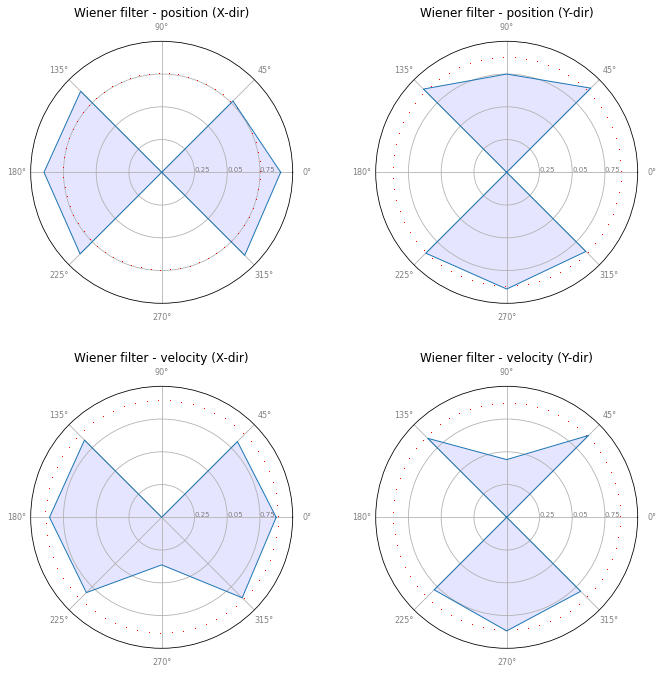

In [30]:
import pandas as pd
from math import pi
import pylab as pl
 
# Set data
df = pd.DataFrame({
'group': ['A'],
'0\N{DEGREE SIGN}': [0.90828433],
'45\N{DEGREE SIGN}': [0.76972034],
'90\N{DEGREE SIGN}': [0],
'135\N{DEGREE SIGN}': [0.87481667],
'180\N{DEGREE SIGN}': [0.89854625],
'225\N{DEGREE SIGN}': [0.88088175],
'270\N{DEGREE SIGN}': [0],
'315\N{DEGREE SIGN}': [0.896327]
})


# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(10,10))    
# Initialise the spider plot
ax1 = plt.subplot(221, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax1.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["0.25","0.05","0.75"], color="grey", size=7)
plt.ylim(0,1)

    
# Plot a circle with radius 2 using polar form
rads = np.arange(0, (2*np.pi), 0.1)

for radian in rads:
    ax1.plot(radian,0.751,'r,')    
    
# Plot data
ax1.plot(angles, values, linewidth=1, linestyle='solid')
ax1.title.set_text('Wiener filter - position (X-dir)')



# Fill area
ax1.fill(angles, values, 'b', alpha=0.1)


#################################

# Set data
df = pd.DataFrame({
'group': ['A'],
'0\N{DEGREE SIGN}': [0],
'45\N{DEGREE SIGN}': [0.90834269],
'90\N{DEGREE SIGN}': [ 0.74997338],
'135\N{DEGREE SIGN}': [0.8986108],
'180\N{DEGREE SIGN}': [0],
'225\N{DEGREE SIGN}': [0.87308245],
'270\N{DEGREE SIGN}': [0.89109282],
'315\N{DEGREE SIGN}': [0.85466042]

})
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]


# Initialise the spider plot
ax2 = plt.subplot(222, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax2.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["0.25","0.05","0.75"], color="grey", size=7)
plt.ylim(0,1)
 
# Circle
for radian in rads:
    ax2.plot(radian,0.872,'r,')    
    
# Plot data
ax2.plot(angles, values, linewidth=1, linestyle='solid')
ax2.title.set_text('Wiener filter - position (Y-dir)')


# Fill area
ax2.fill(angles, values, 'b', alpha=0.1)

####################################

# Set data
df = pd.DataFrame({
'group': ['A'],
'0\N{DEGREE SIGN}': [0.87379461],
'45\N{DEGREE SIGN}': [0.81767131],
'90\N{DEGREE SIGN}': [0],
'135\N{DEGREE SIGN}': [0.83352139],
'180\N{DEGREE SIGN}': [0.85655572],
'225\N{DEGREE SIGN}': [0.81316523],
'270\N{DEGREE SIGN}': [0.3631572],
'315\N{DEGREE SIGN}': [0.86895906]
})

# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]


# Initialise the spider plot
ax3 = plt.subplot(223, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax3.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["0.25","0.05","0.75"], color="grey", size=7)
plt.ylim(0,1)

#Draw circle
  
# setting the radius 

  
# Circle
for radian in rads:
    ax3.plot(radian,0.888,'r,') 
 
# Plot data
ax3.plot(angles, values, linewidth=1, linestyle='solid')
ax3.title.set_text('Wiener filter - velocity (X-dir)')


# Fill area
ax3.fill(angles, values, 'b', alpha=0.1)

############################

# Set data
df = pd.DataFrame({
'group': ['A'],
'0\N{DEGREE SIGN}': [0],
'45\N{DEGREE SIGN}': [ 0.88390918],
'90\N{DEGREE SIGN}': [0.44053351],
'135\N{DEGREE SIGN}': [0.85298412],
'180\N{DEGREE SIGN}': [0],
'225\N{DEGREE SIGN}': [0.78297826],
'270\N{DEGREE SIGN}': [0.86715571],
'315\N{DEGREE SIGN}': [0.79914834]
})
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
values
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]


# Initialise the spider plot
ax4 = plt.subplot(224, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)
 
# Draw ylabels
ax4.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["0.25","0.05","0.75"], color="grey", size=7)
plt.ylim(0,1)

# Circle
for radian in rads:
    ax4.plot(radian,0.867,'r,') 

# Plot data
ax4.plot(angles, values, linewidth=1, linestyle='solid')
ax4.title.set_text('Wiener filter - velocity (Y-dir)')


# Fill area
ax4.fill(angles, values, 'b', alpha=0.1)
fig.tight_layout(pad=3.0)

plt.savefig('WF_single_target')

In [19]:
print(joined_var.shape)


(21133, 2, 3)
